# Elektromos áram fogyasztás

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mavir = pd.read_csv(
    "../data/limited/mavir.csv",
    parse_dates=True,
    index_col="Dátum"
)
mavir.index.freq = "D"

## Plot

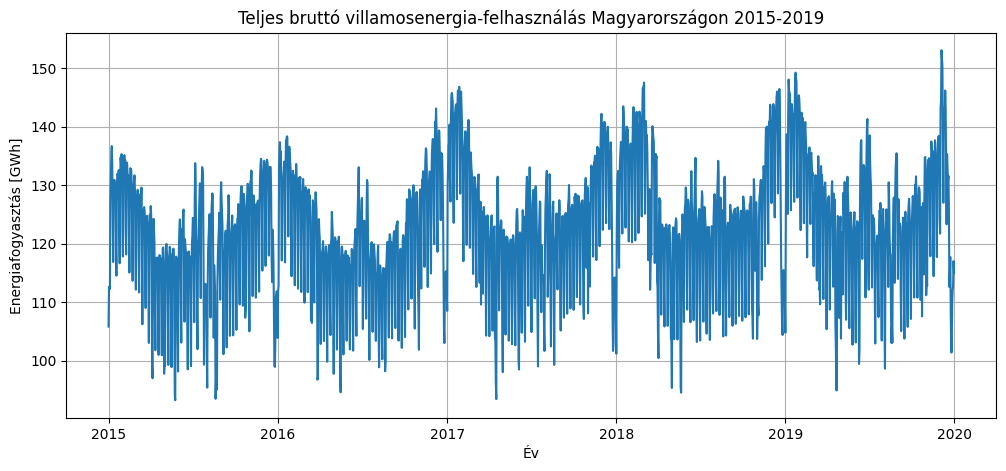

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(mavir)
plt.title("Teljes bruttó villamosenergia-felhasználás Magyarországon 2015-2019")
plt.xlabel("Év")
plt.ylabel("Energiafogyasztás [GWh]")
plt.grid(True)
plt.savefig("../docs/figures/mavir.png")
plt.savefig("../docs/figures/mavir.svg")
plt.show()

## Kézi dekomponálás

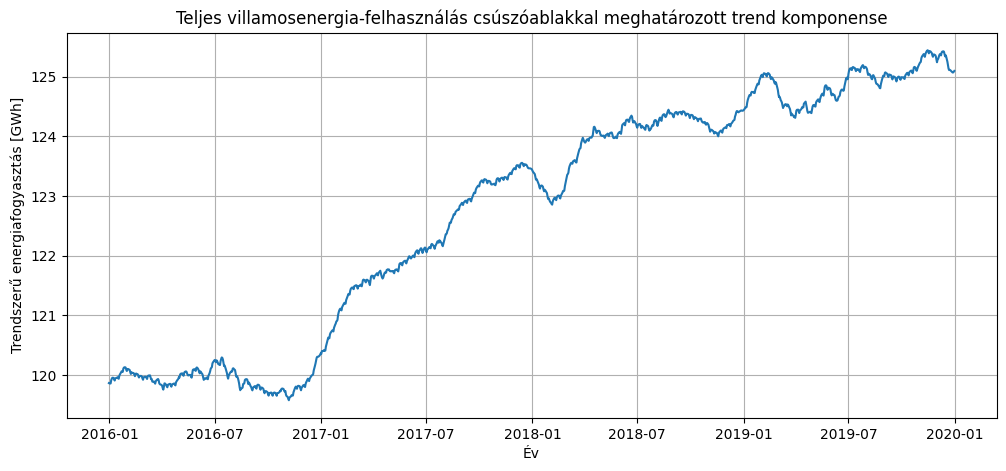

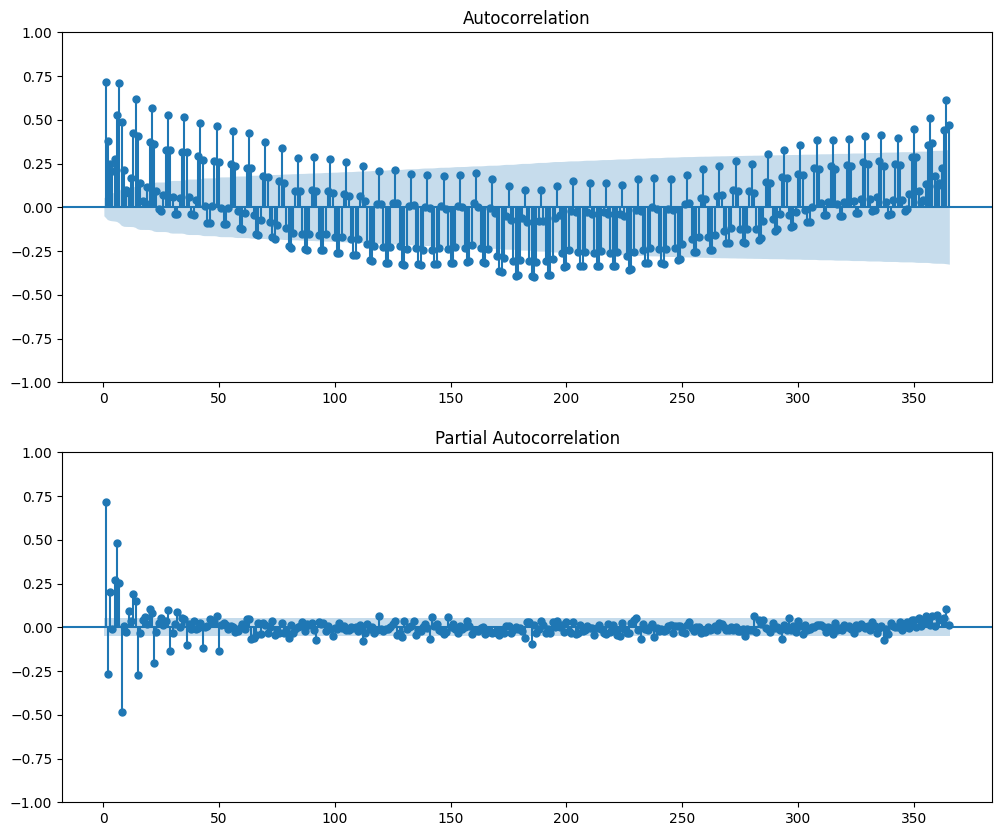

In [12]:
N = 365
mavir_trend = mavir.rolling(N).mean()
mavir_residual = mavir-mavir_trend
mavir_trend = mavir_trend.dropna()
mavir_residual = mavir_residual.dropna()
plt.figure(figsize=(12, 5))
plt.title("Teljes villamosenergia-felhasználás csúszóablakkal meghatározott trend komponense")
plt.xlabel("Év")
plt.ylabel("Trendszerű energiafogyasztás [GWh]")
plt.grid(True)
plt.plot(mavir_trend)
plt.savefig("../docs/figures/mavir_trend_by_hand.png")
plt.savefig("../docs/figures/mavir_trend_by_hand.svg")
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
plot_acf(mavir_residual, lags=365, zero=False, ax=ax1)
plot_pacf(mavir_residual, lags=365, zero=False, ax=ax2)
plt.savefig("../docs/figures/mavir_residual_acf_by_hand.png")
plt.savefig("../docs/figures/mavir_residual_acf_by_hand.svg")
plt.show()

## Split dataset

In [5]:
mavir_train = mavir.loc[:"2018"]
mavir_test = mavir.loc["2019":]
mavir_train.index.freq = "D"
mavir_test.index.freq = "D"

## SARIMA

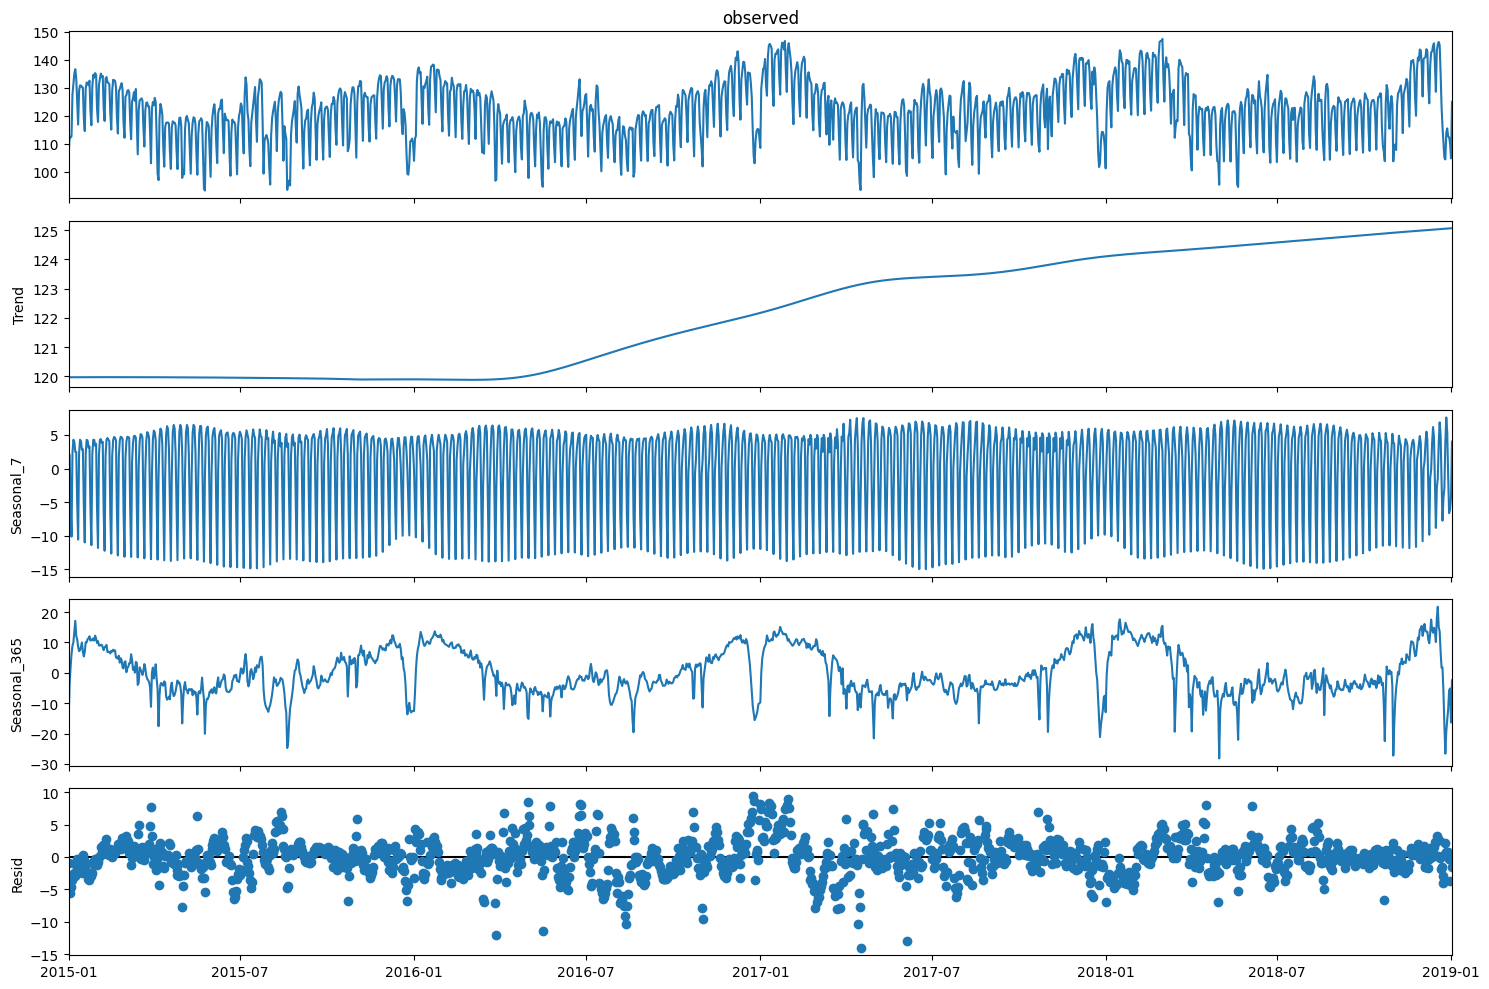

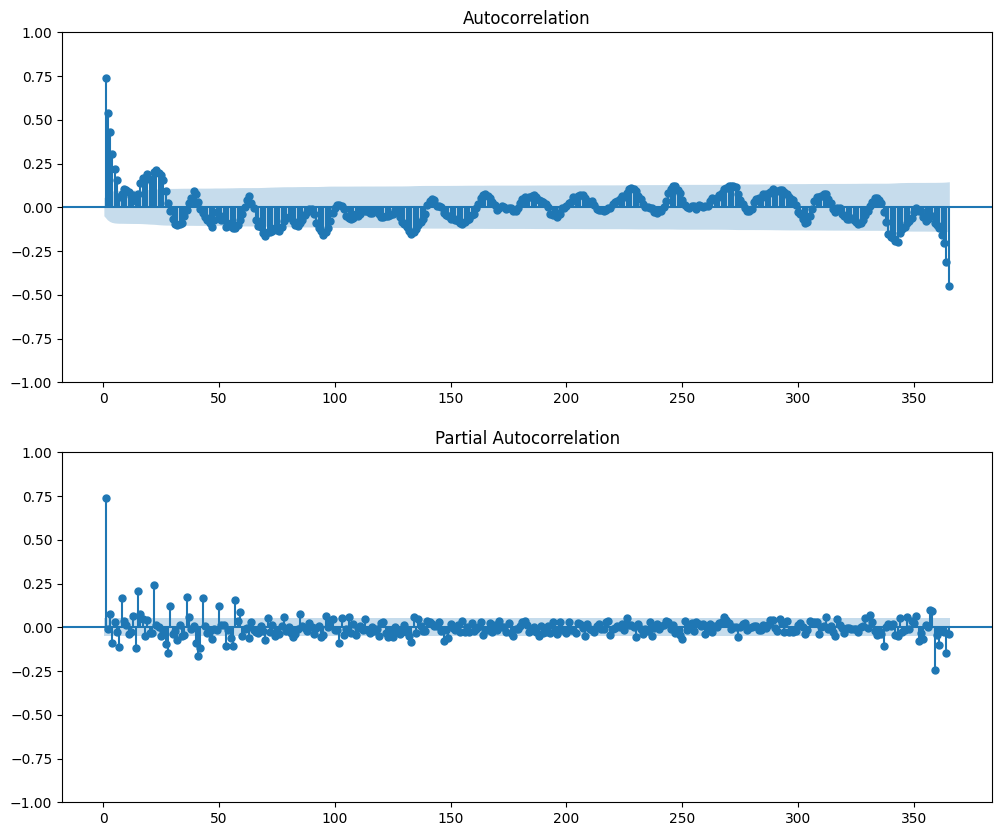

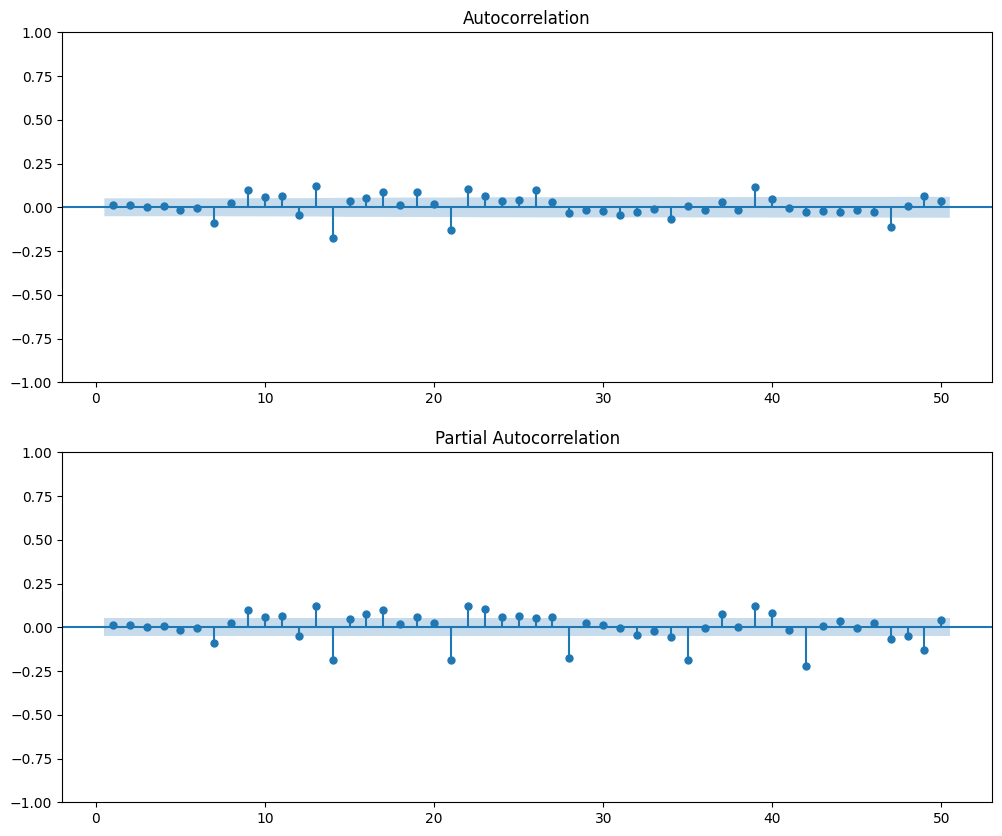

/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import MSTL

# 1. Step: Create MSTL model with weekly and yearly periodicity
mstl = MSTL(mavir_train["Energiafogyasztás"], periods=(7, 365))
mstl_result = mstl.fit()
fig = mstl_result.plot()
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()


# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
plot_acf(mstl_result.resid, lags=365, zero=False, ax=ax1)
plot_pacf(mstl_result.resid, lags=365, zero=False, ax=ax2)
plt.show()

# 2. Step: plot residuals ARIMA
resid_arima = ARIMA(mstl_result.resid, order=(7, 0, 1)).fit()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
plot_acf(resid_arima.resid, lags=50, zero=False, ax=ax1)
plot_pacf(resid_arima.resid, lags=50, zero=False, ax=ax2)
plt.show()


# Forecasting
mavir_forecast = pd.DataFrame(
    index=mavir_test.index,
    columns=mavir_test.columns
)
for i, date in enumerate(mavir_test.index):
    # Create MSTL model with weekly and yearly periodicity
    mstl = MSTL(mavir_train["Energiafogyasztás"], periods=(7, 365))
    mstl_result = mstl.fit()

    # Decomposition
    trend = mstl_result.trend
    seasonal_007 = mstl_result.seasonal.iloc[:, 0]
    seasonal_365 = mstl_result.seasonal.iloc[:, 1]
    resid = mstl_result.resid

    resid_arima = ARIMA(resid, order=(7, 0, 1)).fit()

    # Forecasting
    trend_forecast = trend.iloc[-1]
    seasonal_007_forecast = seasonal_007.iloc[-(7 - (i % 7))] if i % 7 != 0 else seasonal_007.iloc[-7]
    seasonal_365_forecast = seasonal_365.iloc[-(365 - (i % 365))] if i % 365 != 0 else seasonal_365.iloc[-365]

    seasonal_forecast = seasonal_007_forecast + seasonal_365_forecast 
    resid_forecast = resid_arima.forecast(steps=1).iloc[0]

    forecast = trend_forecast + seasonal_forecast + resid_forecast

    mavir_forecast.loc[date, "Energiafogyasztás"] = forecast

    actual_value = mavir_test.loc[date, "Energiafogyasztás"]

    new_row = pd.DataFrame(
        {"Energiafogyasztás": [actual_value]}, 
        index=[date]
    )
    new_row.index.freq = "D"
    mavir_train = pd.concat([mavir_train, new_row])

In [ ]:
# Plot the result
plt.figure(figsize=(12, 5))

# Plot actual data (differences)
plt.plot(
    mavir_test.index,
    mavir_test["Energiafogyasztás"], 
    label="Tényadat",
    color="blue",
    linewidth=1,
)

# Plot forecasted data
plt.plot(
    mavir_forecast.index,
    mavir_forecast["Energiafogyasztás"],
    label="Előrejelzett érték",
    color="green",
    linewidth=1,
)

plt.title("Teljes bruttó villamosenergia-felhasználás előrejelzés 2019-re")
plt.xlabel("Év")
plt.ylabel("Elektromos energiafogyasztás")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../docs/figures/mavir_daily_forecast.png")
plt.savefig("../docs/figures/mavir_daily_forecast.svg")
plt.show()